In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime

# Do you wanna see?
verbose = True

In [6]:
# FMNS testing pull request

In [56]:
def transformData(dataset, datainfo):
  
    # Use the column-name information to rename the columns.
    renameCol = {i:col[0] for i,col in enumerate(datainfo)}
  
    # Rename
    dataset = dataset.rename(columns=renameCol)
  
    # Use the datatype information to convert the arrays back to the right datatype.
    dt = {col[0]:str if col[1] == 'object' else col[1] for col in datainfo}

    # Convert the datatypes
    dataset = dataset.astype(dt)

    # Strip the string-type arrays for the unintended characters.
    for ele in datainfo:
        # if the datatype is string, we need to do some additional conversion.
        if ele[1] == 'object':

            dataset[ele[0]] = list(map(f,dataset[ele[0]]))

            if 'date' in ele[0].lower():
                dataset[ele[0]] = dataset[ele[0]].astype(np.datetime64) 

    return dataset

# We create a function to clean the string-type arrays
f = lambda a: re.split('[\']',a)[1]

# Function to clean the unpacked data from the compressed files.
def strList(ls):
    return list(map(lambda x: x.decode('utf-8'),ls))

# The following function is based on the research of (Lunde, 2016), summarized in the slides found here:
# https://econ.au.dk/fileadmin/site_files/filer_oekonomi/subsites/creates/Diverse_2016/PhD_High-Frequency/HF_TrQuData_v01.pdf

def formatDate(date,timestamps):
    return list(map(lambda x: date[0:4]+'/'+date[4:6]+'/'+date[6:]+' '+str(datetime.timedelta(seconds = int(str(x)[0:5]),
                                                     microseconds = int(str(x)[5:11]))),timestamps))
def HFDataCleaning(cleaningProcedures,dataToClean,dataType,p3Exchanges = []):
    
    # There are 11 cleaning procedures, with 3 relevant for both trade and quote data and 4 for either trade or quote data.
    # The cleaning procedures are listed below for simplicity
    
    # Applicable for both trade and quote data
    
    # P1. Delete entries with a time stamp outside the 9:30 am to 4 pm window when the exchange is open.
    # P2. Delete entries with a bid, ask or transaction price equal to zero.
    # P3. Retain entries originating from a single exchange. Delete other entries.
    
    # Applicable for just trade data
    
    # T1. Delete entries with corrected trades. (Trades with a Correction Indicator, CORR != 0).
    # T2. Delete entries with abnormal Sale Condition. (Trades where COND has a letter code, except for “E” and “F”).
    # T3. If multiple transactions have the same time stamp: use the median price.
    # T4. Delete entries with prices that are above the ask plus the bid-ask spread. 
    # Similar for entries with prices below the bid minus the bid-ask spread.
    
    # Applicable for just quote data
    
    # Q1. When multiple quotes have the same timestamp, we replace all these with a single entry 
    # with the median bid and median ask price.
    # Q2. Delete entries for which the spread is negative.
    # Q3. Delete entries for which the spread is more that 50 times the median spread on that day.
    # Q4. Delete entries for which the mid-quote deviated by more than 5 median absolute deviations from 
    # a centered median (excluding the observation under consideration) of 50 observations.

    # Some comments, by (Lunde,2016), on the relative importance of the individual cleaning procedures
    
    # ➤ By far the most important rules here are P3, T3 and Q1.
    # ➤ In our empirical work we will see the impact of suspending P3. It is used to reduce the impact
    # of time-delays in the reporting of trades and quote updates.
    # ➤ Some form of T3 and Q1 rule seems inevitable here, and it is these rules which lead to the largest deletion of data.
    # ➤ T4 is an attractive rule, as it disciplines the trade data using quotes. However, it has the disadvantage 
    # that it cannot be applied when quote data is not available.
    # ➤ In situations where quote data is not available, Q4 can be applied to the transaction prices in place of T4.

    dataType = dataType.lower().strip()
    
  
        
    for cp in cleaningProcedures:
        
        cp = cp.lower().strip()
        
        
        # check if cp is sensible
        if (cp.startswith('t')) & (dataType != 'trade'):
            raise ValueError(f'Cleaning procedure {cp} is not compatible with dataType {dataType}')  
            
        elif (cp.startswith('q')) & (dataType != 'quote'):
            raise ValueError(f'Cleaning procedure {cp} is not compatible with dataType {dataType}') 


        # if the cleaning procedure in question is p1.
        if cp == 'p1':
            # ((tradeData.Hour+tradeData.Minute/60)>9.5)&((tradeData.Hour+tradeData.Minute/60)<16)
#             dataToClean = dataToClean[(datetime.timedelta(hours = 9,
#                                                          minutes = 30) <= dataToClean.Timestamp)&\
#                                       (dataToClean.Timestamp <= datetime.timedelta(hours = 16,
#                                                                                    minutes = 0))].reset_index(drop=True)
            dataToClean = dataToClean[((dataToClean.Hour+dataToClean.Minute/60)>=9.5)&\
                                      ((dataToClean.Hour+dataToClean.Minute/60)<16)]
        
        # if the cleaning procedure in question is p2.
        elif cp == 'p2':
            
            # if the cleaning procedure in question is p1.
            if dataType == 'trade':
                
                dataToClean = dataToClean[dataToClean.price != 0].reset_index(drop=True)
                
            elif dataType == 'quote':
                
                dataToClean = dataToClean[(dataToClean.bid != 0) | (dataToClean.ofr != 0)].reset_index(drop=True)
                
                
        # if the cleaning procedure in question is p3.
        elif cp == 'p3':
            
            if len(p3Exchanges) == 0:
                
                raise ValueError('No exchanges, to filter on, has been provided.\nPlease provide a list with minimum one exchanges to filter on.')
            
            else:
                
                # Ensuring correct format
                p3Exchanges = [ele.lower().strip() for ele in p3Exchanges]
                
                # Filtering on exchanges ### Consider to use "isin" on the dataToClean.ex-Series instead, to improve execution time.
                dataToClean = dataToClean[[True if ele.lower().strip() in p3Exchanges else False for ele in dataToClean.ex]].reset_index(drop=True)
        
        
        # if the cleaning procedure in question is t1.
        # T1. Delete entries with corrected trades. (Trades with a Correction Indicator, CORR != 0).
        elif cp == 't1':

            dataToClean = dataToClean[dataToClean['corr'] == '00'].reset_index(drop=True)                
                
                
        # if the cleaning procedure in question is t2.
        # T2. Delete entries with abnormal Sale Condition. (Trades where COND has a letter code, except for “E” and “F”).
        # FMNS: Most are COND = '@ XX' such as '@ TI', make sure this works properly. Assuming startswith('@') is cool
        elif cp == 't2':
            
            dataToClean = dataToClean[(dataToClean.cond.startswith('@')) | (dataToClean.cond in ['E', 'F'])].reset_index(drop=True) 
            
            
        # if the cleaning procedure in question is t3.
        # T3. If multiple transactions have the same time stamp: use the median price.
        # FMNS: Let's consider if these median prices are cheating in relation to OHLC bars
        elif cp == 't3':

            # get unique timestamps
            unique_ts_idx = np.unique(dataToClean.Timestamp, return_index=True)[1]
            
            # get median prices
            median_price = dataToClean[['Timestamp', 'price']].groupby('Timestamp')['price'].median().values
                
            # keep only unique timestamps
            dataToClean = dataToClean.iloc[unique_ts_idx, :].reset_index(drop=True)
            
            # fill the price variable with medians matched on unique_ts
            dataToClean.loc[:,'price'] = median_price
            
            ### We could add a print to tell how many duplicated values there where? - Kris
            
            # note that all other variables now hold the first entry for each timestamp!

            
        # if the cleaning procedure in question is t3.        
        # T4. Delete entries with prices that are above the ask plus the bid-ask spread. 
        # Similar for entries with prices below the bid minus the bid-ask spread.
        # FMNS: We have no bid/ask/spread in trades-table. 
        #       To do this, we would probably need to cross-match timestamps between trades and quotes properly
        elif cp == 't4':
            
            raise ValueError(f'Cleaning procedure {cp} is on hold')          

            
        # if the cleaning procedure in question is q1.
        # Q1. When multiple quotes have the same timestamp, we replace all these with a single entry 
        # with the median bid and median ask price.   
        # FMNS: Let's consider if these median prices are cheating in relation to OHLC bars
        elif cp == 'q1':
            
            if datatype == 'quote':
            
                # get unique timestamps
                unique_ts_idx = np.unique(dataToClean.Timestamp, return_index=True)[1]

                # get median prices
                median_price = dataToClean[['Timestamp', 'bid', 'ofr']].groupby('Timestamp')['bid', 'ofr'].median().values

                # keep only unique timestamps
                dataToClean = dataToClean.iloc[unique_ts_idx, :].reset_index(drop=True)

                # fill the price variable with medians matched on unique_ts
                dataToClean.loc[:,['bid','ofr']] = median_price

                # note that all other variables now hold the first entry for each timestamp!
            
            else:
                
                raise ValueError('The datatype has to be quote, in order to apply this cleaning procedure.\nPlease revisit your request.')
            

        # if the cleaning procedure in question is q2.
        # Q2. Delete entries for which the spread is negative.
        elif cp == 'q2':
            
            if datatype == 'quote':
                
                dataToClean = dataToClean[dataToClean.ofr - dataToClean.bid >= 0].reset_index(drop=True)     
            
            else:
                raise ValueError('The datatype has to be quote, in order to apply this cleaning procedure.\nPlease revisit your request.')

        # if the cleaning procedure in question is q3.
        # Q3. Delete entries for which the spread is more that 50 times the median spread on that day.
        elif cp == 'q3':
            
            if datatype == 'quote':
                
                # get all spreads across days, groupby Date and take daily median spreads
                all_spreads = dataToClean[['Date', 'bid', 'ofr']]
                all_spreads['spread'] =  dataToClean.ofr - dataToClean.bid
                all_spreads.drop(['bid','ofr'], axis=1, inplace=True)

                median_spreads = all_spreads.groupby('Date').median().values     


                total_keep_idx = []
                # for each unique day ...
                for day in np.unique(dataToClean.Date):

                    # for every spread within this day, check if it's below 50*median 
                    # (below_50median is a boolean with all existing index)
                    below_50median = (all_spreads[all_spreads.Date == day].spread <= 50*median_spreads[median_spreads.index == day].values[0][0])

                    # get the indices where below_50median == True (meaning individual spread is within 50*median)
                    below_50median[below_50median].index

                    total_keep_idx.append(below_50median[below_50median].index)


                # after going through all days, flatten the list
                total_keep_idx = [ele for intraday_idx in total_keep_idx for ele in intraday_idx]

                # keep all entries that passed the filter
                dataToClean = dataToClean.iloc[total_keep_idx, :]
            
            else:

                raise ValueError('The datatype has to be quote, in order to apply this cleaning procedure.\nPlease revisit your request.')
        
        # if the cleaning procedure in question is q4.
        # Q4. Delete entries for which the mid-quote deviated by more than 5 median absolute deviations from 
        # a centered median (excluding the observation under consideration) of 50 observations.        
        elif cp == 'q4':
            
            raise ValueError(f'Cleaning procedure {cp} is on hold')
    return dataToClean

# Reading in data, LOBSTER as well as TAQ

## TAQ

In [8]:
print(os.listdir())
path = 'a:/taqhdf5'
allFiles = os.listdir(path)

['.git', '.gitignore', '.ipynb_checkpoints', 'CrunchTAQ.ipynb', 'hello.py', 'README.md', 'Speciale to-do.docx', 'Speciale to-do.txt']


In [9]:
#allFiles
len(allFiles), allFiles[:5], allFiles[-5:]

(8515,
 ['taq_19930315.h5',
  'taq_19930104.h5',
  'taq_19930317.h5',
  'taq_19930105.h5',
  'taq_19930316.h5'],
 ['taqquote_20200522.h5',
  'taqquote_20200526.h5',
  'taqquote_20200527.h5',
  'taqquote_20200528.h5',
  'taqquote_20200529.h5'])

In [10]:
allFiles[-10:]

['taqquote_20200515.h5',
 'taqquote_20200518.h5',
 'taqquote_20200519.h5',
 'taqquote_20200520.h5',
 'taqquote_20200521.h5',
 'taqquote_20200522.h5',
 'taqquote_20200526.h5',
 'taqquote_20200527.h5',
 'taqquote_20200528.h5',
 'taqquote_20200529.h5']

In [39]:
dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,32)])

In [40]:
dates

array(['20200401', '20200402', '20200403', '20200404', '20200405',
       '20200406', '20200407', '20200408', '20200409', '20200410',
       '20200411', '20200412', '20200413', '20200414', '20200415',
       '20200416', '20200417', '20200418', '20200419', '20200420',
       '20200421', '20200422', '20200423', '20200424', '20200425',
       '20200426', '20200427', '20200428', '20200429', '20200430',
       '20200431'], dtype='<U8')

In [41]:
# Measuring the exraction time
start = time.time()

# Provide a list of dates of interest (format: yyyymmdd)
dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,32)]).astype(int)
# dates = np.array(['20200401']).astype(int)#,'20200402'

# Provide a list of tickers of interest
tickers = ['GOOG']#'MSFT'

# Do we need data on trades, quotes or both?
dataNeeded = 'trades' # 'trades', 'quotes' or 'both'

# Extracting just the dates of each file
allDates = np.array([re.split("[._]",ele)[1] if ("." in ele ) & ("_" in ele) else 0 for ele in allFiles]).astype(int)

minDate = np.min(dates)
maxDate = np.max(dates)

if verbose:
    print('##### Date range #####\n\nDate, Min: %i\nDate, Max: %i\n'%(minDate,maxDate))

# Locating what files we need.
index = np.where((minDate <= allDates) & (allDates <= maxDate))

relevantFiles = np.array(allFiles)[index[0]]

# Separating the files into trade and quote files.
trade = [ele for ele in relevantFiles if 'trade' in ele]
quote = [ele for ele in relevantFiles if 'quote' in ele]

if verbose:
    print('##### Data Extraction begins #####\n')
    
    if dataNeeded.lower() == 'both':
        print('Both trade and quote data is being extracted..\n')
    else:
        print('%s data is being extracted..\n' % dataNeeded[0:5])
        
if (dataNeeded == 'both') | (dataNeeded == 'trades'):
           
# Lets start out by extracting the trade data

    for i,file in enumerate(trade):

        if (verbose) & (i == 0):
            print('### Trade Data ###\n')

        # Reading one file at a time
        raw_data = h5py.File(path+'/'+file,'r')

        # Store the trade indecies
        TI = raw_data['TradeIndex']

        if (verbose) & (i==0):
            print('The raw H5 trade file contains: ',list(raw_data.keys()),'\n')

        # Extracting just the tickers
        TIC = np.array([ele[0].astype(str).strip() for ele in TI])

        # Lets get data on each ticker for the file processed at the moment
        for j,ticker in enumerate(tickers):

            # Getting the specific ticker information
            tickerInfo = TI[TIC==ticker][0]

            if (verbose) & (i == 0):
                    print('Ticker Information: ',tickerInfo,'\n')

            # Raw data
            tempData = raw_data['Trades'][np.arange(tickerInfo[1],tickerInfo[1]+tickerInfo[2])]

            # For first file and first ticker.
            if (i == 0) & (j == 0):    

                tradeData = pd.DataFrame(tempData, columns= tempData.dtype.names)

                tradeData.loc[:,'ex'] = strList(tradeData.ex)
                tradeData.loc[:,'cond'] = strList(tradeData.cond)
                tradeData.loc[:,'TradeStopStockIndicator'] = strList(tradeData.TradeStopStockIndicator)
                tradeData.loc[:,'corr'] = strList(tradeData['corr'])
                tradeData.loc[:,'TradeID'] = strList(tradeData.TradeID)
                tradeData.loc[:,'TTE'] = strList(tradeData.TTE)
                tradeData.loc[:,'TradeReportingFacility'] = strList(tradeData.TradeReportingFacility)
                tradeData.loc[:,'SourceOfTrade'] = strList(tradeData.SourceOfTrade)

                # Adding the date of the file to the dataframe.
                tradeData['Date'] = re.split('[._]',file)[1]

                # Adding a more readable timestamp - TEST IT
                tradeData['Timestamp'] = pd.to_datetime(formatDate(re.split('[._]',file)[1],tradeData.utcsec))
                tradeData['TSRemainder'] = list(map(lambda x: str(x)[11:], tradeData.utcsec))
                tradeData['Hour'] = tradeData.Timestamp.dt.hour
                tradeData['Minute'] = tradeData.Timestamp.dt.minute
                # Adding the ticker
                tradeData['Ticker'] = ticker

                if (verbose) & (i==0) & (j==0):
                    print('Sneak peak of the data\n\n',tradeData.head())

            else:

                # Storing the data on the following tickers in a temporary variable.

                temp = pd.DataFrame(tempData, columns= tempData.dtype.names)

                temp.loc[:,'ex'] = strList(temp.ex)
                temp.loc[:,'cond'] = strList(temp.cond)
                temp.loc[:,'TradeStopStockIndicator'] = strList(temp.TradeStopStockIndicator)
                temp.loc[:,'corr'] = strList(temp['corr'])
                temp.loc[:,'TradeID'] = strList(temp.TradeID)
                temp.loc[:,'TTE'] = strList(temp.TTE)
                temp.loc[:,'TradeReportingFacility'] = strList(temp.TradeReportingFacility)
                temp.loc[:,'SourceOfTrade'] = strList(temp.SourceOfTrade)

                # Adding the date of the file to the dataframe.
                temp['Date'] = re.split('[._]',file)[1]

                # Adding a more readable timestamp - TEST IT
                temp['Timestamp'] = pd.to_datetime(formatDate(re.split('[._]',file)[1],temp.utcsec))
                temp['TSRemainder'] = list(map(lambda x: str(x)[11:], temp.utcsec))
                temp['Hour'] = temp.Timestamp.dt.hour
                temp['Minute'] = temp.Timestamp.dt.minute

                # Adding the ticker
                temp['Ticker'] = ticker

                # Adding the new data 
                tradeData = pd.concat([tradeData,temp])

if (dataNeeded == 'both') | (dataNeeded == 'quotes'):
    
    # Now to the quote data
    for i,file in enumerate(quote):

        if (verbose) & (i == 0):
            print('### Quote Data ###\n')

        # Reading one file at a time
        raw_data = h5py.File(path+'/'+file,'r')

        # Store the trade indecies
        QI = raw_data['QuoteIndex']

        if (verbose) & (i==0):
            print('The raw H5 quote file contains: ',list(raw_data.keys()),'\n')

        # Extracting just the tickers
        QIC = np.array([ele[0].astype(str).strip() for ele in QI])

        # Lets get data on each ticker for the file processed at the moment
        for j,ticker in enumerate(tickers):

            # Getting the specific ticker information
            tickerInfo = QI[QIC==ticker][0]

            if (verbose) & (i == 0):
                    print('Ticker Information: ',tickerInfo,'\n')

            # Raw data
            tempData = raw_data['Quotes'][np.arange(tickerInfo[1],tickerInfo[1]+tickerInfo[2])]

            # For first file and first ticker.
            if (i == 0) & (j == 0):    

                quoteData = pd.DataFrame(tempData, columns= tempData.dtype.names)
                # We remove all unnecessary variables
                unnecessaryVariables = ['NationalBBOInd',
                                        'FinraBBOInd',
                                        'FinraQuoteIndicator',
                                        'SequenceNumber',
                                        'FinraAdfMpidIndicator',
                                        'QuoteCancelCorrection',
                                        'SourceQuote',
                                        'RPI',
                                        'ShortSaleRestrictionIndicator',
                                        'LuldBBOIndicator',
                                        'SIPGeneratedMessageIdent',
                                        'NationalBBOLuldIndicator',
                                        'ParticipantTimestamp',
                                        'FinraTimestamp',
                                        'FinraQuoteIndicator',
                                        'SecurityStatusIndicator']
                
                quoteData = quoteData.drop(columns=unnecessaryVariables)

                quoteData.loc[:,'ex'] = strList(quoteData.ex)
                quoteData.loc[:,'mode'] = strList(quoteData['mode'])
                
                # Adding the date of the file to the dataframe.
                quoteData['Date'] = re.split('[._]',file)[1]

                # Adding a more readable timestamp - TEST IT
                quoteData['Timestamp'] = pd.to_datetime(formatDate(re.split('[._]',file)[1],quoteData.utcsec))
                quoteData['TSRemainder'] = list(map(lambda x: str(x)[11:], quoteData.utcsec))
                quoteData['Hour'] = quoteData.Timestamp.dt.hour
                quoteData['Minute'] = quoteData.Timestamp.dt.minute
                # Adding the ticker
                quoteData['Ticker'] = ticker

                if (verbose) & (i==0) & (j==0):
                    print('Sneak peak of the data\n\n',quoteData.head())

            else:

                # Storing the data on the following tickers in a temporary variable.

                temp = pd.DataFrame(tempData, columns= tempData.dtype.names)
                # Removing all unnecessary variables
                temp = temp.drop(columns=unnecessaryVariables)
                
                temp.loc[:,'ex'] = strList(temp.ex)
                temp.loc[:,'mode'] = strList(temp['mode'])

                # Adding the date of the file to the dataframe.
                temp['Date'] = re.split('[._]',file)[1]

                # Adding a more readable timestamp - TEST IT
                temp['Timestamp'] = pd.to_datetime(formatDate(re.split('[._]',file)[1],temp.utcsec))
                temp['TSRemainder'] = list(map(lambda x: str(x)[11:], temp.utcsec))
                temp['Hour'] = temp.Timestamp.dt.hour
                temp['Minute'] = temp.Timestamp.dt.minute

                # Adding the ticker
                temp['Ticker'] = ticker

                # Adding the new data 
                quoteData = pd.concat([quoteData,temp])
                    
end = time.time()

if verbose:
    print('The extraction time was %.3f seconds.' % (end-start))

##### Date range #####

Date, Min: 20200401
Date, Max: 20200431

##### Data Extraction begins #####

trade data is being extracted..

### Trade Data ###

The raw H5 trade file contains:  ['TradeIndex', 'Trades'] 

Ticker Information:  (b'GOOG            ', 26900500, 71427) 

Sneak peak of the data

            utcsec ex  cond  volume    price TradeStopStockIndicator corr  \
0  14400048517953  P  @ TI      67  1139.44                           00   
1  14422296771981  P  @ TI      20  1138.55                           00   
2  14429472894282  Q  @FTI       1  1138.54                           00   
3  14506997225243  P  @ TI      31  1143.65                           00   
4  14516526073882  P  @ TI       1  1143.59                           00   

   TradeSequenceNumber TradeID SourceOfTrade TradeReportingFacility  \
0                 1507       1             N                          
1                 1552       2             N                          
2                 1554       

In [12]:
# quoteData.head()
tradeData.head()

,utcsec,ex,cond,volume,price,TradeStopStockIndicator,corr,TradeSequenceNumber,TradeID,SourceOfTrade,TradeReportingFacility,ParticipantTime,TRFTime,TTE,Date,Timestamp,TSRemainder,Hour,Minute,Ticker
0,14400048517953,P,@ TI,67,1139.44,,00,1507,1,N,,14400048141056,99,0,20200401,2020-04-01 04:00:00.048517,953,4,0,GOOG
1,14422296771981,P,@ TI,20,1138.55,,00,1552,2,N,,14422296394240,99,0,20200401,2020-04-01 04:00:22.296771,981,4,0,GOOG
2,14429472894282,Q,@FTI,1,1138.54,,00,1554,1,N,,14429472872353,99,1,20200401,2020-04-01 04:00:29.472894,282,4,0,GOOG
3,14506997225243,P,@ TI,31,1143.65,,00,1581,3,N,,14506996848640,99,0,20200401,2020-04-01 04:01:46.997225,243,4,1,GOOG
4,14516526073882,P,@ TI,1,1143.59,,00,1587,4,N,,14516525699840,99,0,20200401,2020-04-01 04:01:56.526073,882,4,1,GOOG


In [13]:
tradeData[['Date','Ticker','utcsec']].groupby(['Date','Ticker']).count()
# quoteData[['Date','Ticker','utcsec']].groupby(['Date','Ticker']).count()

,,utcsec
Date,Ticker,
20200401,GOOG,71427


In [14]:
tradeData.cond.unique()

array(['@ TI', '@FTI', '@FT ', '@ T ', '@  I', '@   ', '@  Q', '@F I',
       '@O X', '@F  ', '@4 I', '@4  ', '@4ZI', '@ ZI', '@ Z ', '@4 W',
       'N  I', '@7 V', 'C  I', '@  W', '@  M', '@6 X', '@ TW', 'N T ',
       '@ TP'], dtype=object)

In [15]:
tradeData[['cond','utcsec']].groupby('cond').count()

,utcsec
cond,
@,6123
@ I,37366
@ M,2
@ Q,2
@ W,1
@ T,36
@ TI,1263
@ TP,2
@ TW,1


In [16]:
tradeData[tradeData.duplicated(['utcsec'])]
# quoteData[quoteData.duplicated(['utcsec'])]

,utcsec,ex,cond,volume,price,TradeStopStockIndicator,corr,TradeSequenceNumber,TradeID,SourceOfTrade,TradeReportingFacility,ParticipantTime,TRFTime,TTE,Date,Timestamp,TSRemainder,Hour,Minute,Ticker


In [45]:
tradeData[['ex','utcsec']].groupby('ex').count()

,utcsec
ex,
A,4496
B,15429
C,5061
D,385483
J,16638
K,86287
M,1122
N,10326
P,168475


# Implementing technical features

A library: https://technical-analysis-library-in-python.readthedocs.io/en/latest/

### Features used in the literature:

* Stochastic K
* Stochastic D
* Slow Stochastic D
* Momentum
* ROC
* Williams % R
* A/D Oscillator
* Disparity 5
* Disparity 10
* Price Oscillator
* Commodity Channel Index
* RSI

Formulas: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=876544

* Moving Average
* Bias
* Exponential Moving Average
* Difference
* True Range
* 

Formulas: https://www.sciencedirect.com/science/article/pii/S0957417407001819?via%3Dihub

**Non-classical technical features**

* Bid/Ask prices of top of book
* Spread and mid price based on top og book
* Price derivatives

Formulas: https://www.tandfonline.com/doi/full/10.1080/14697688.2015.1032546?instName=UCL+%28University+College+London%29

# Aggregation - going from irregular spaced data to regular spaced data.

Financial econometric analysis at ultra-high frequency: Data handling concerns

Paper: https://www.sciencedirect.com/science/article/pii/S0167947306003458

In [17]:
tradeData.head()

,utcsec,ex,cond,volume,price,TradeStopStockIndicator,corr,TradeSequenceNumber,TradeID,SourceOfTrade,TradeReportingFacility,ParticipantTime,TRFTime,TTE,Date,Timestamp,TSRemainder,Hour,Minute,Ticker
0,14400048517953,P,@ TI,67,1139.44,,00,1507,1,N,,14400048141056,99,0,20200401,2020-04-01 04:00:00.048517,953,4,0,GOOG
1,14422296771981,P,@ TI,20,1138.55,,00,1552,2,N,,14422296394240,99,0,20200401,2020-04-01 04:00:22.296771,981,4,0,GOOG
2,14429472894282,Q,@FTI,1,1138.54,,00,1554,1,N,,14429472872353,99,1,20200401,2020-04-01 04:00:29.472894,282,4,0,GOOG
3,14506997225243,P,@ TI,31,1143.65,,00,1581,3,N,,14506996848640,99,0,20200401,2020-04-01 04:01:46.997225,243,4,1,GOOG
4,14516526073882,P,@ TI,1,1143.59,,00,1587,4,N,,14516525699840,99,0,20200401,2020-04-01 04:01:56.526073,882,4,1,GOOG


In [42]:
tradeData.shape

(1397583, 20)

In [53]:
tradeData[['corr','utcsec']].groupby('corr').count()

,utcsec
corr,
00,1397517
01,12
08,21
10,21
12,12


In [58]:
# There are 11 cleaning procedures, with 3 relevant for both trade and quote data and 4 for either trade or quote data.
    # The cleaning procedures are listed below for simplicity
    
    # Applicable for both trade and quote data
    
    # P1. Delete entries with a time stamp outside the 9:30 am to 4 pm window when the exchange is open.
    # P2. Delete entries with a bid, ask or transaction price equal to zero.
    # P3. Retain entries originating from a single exchange. Delete other entries.
    
    # Applicable for just trade data
    
    # T1. Delete entries with corrected trades. (Trades with a Correction Indicator, CORR != 0).
    # T2. Delete entries with abnormal Sale Condition. (Trades where COND has a letter code, except for “E” and “F”).
    # T3. If multiple transactions have the same time stamp: use the median price.
    # T4. Delete entries with prices that are above the ask plus the bid-ask spread. 
    # Similar for entries with prices below the bid minus the bid-ask spread.
    
    # Applicable for just quote data
    
    # Q1. When multiple quotes have the same timestamp, we replace all these with a single entry 
    # with the median bid and median ask price.
    # Q2. Delete entries for which the spread is negative.
    # Q3. Delete entries for which the spread is more that 50 times the median spread on that day.
    # Q4. Delete entries for which the mid-quote deviated by more than 5 median absolute deviations from 
    # a centered median (excluding the observation under consideration) of 50 observations.

    # Some comments, by (Lunde,2016), on the relative importance of the individual cleaning procedures
    
    # ➤ By far the most important rules here are P3, T3 and Q1.
    # ➤ In our empirical work we will see the impact of suspending P3. It is used to reduce the impact
    # of time-delays in the reporting of trades and quote updates.
    # ➤ Some form of T3 and Q1 rule seems inevitable here, and it is these rules which lead to the largest deletion of data.
    # ➤ T4 is an attractive rule, as it disciplines the trade data using quotes. However, it has the disadvantage 
    # that it cannot be applied when quote data is not available.
    # ➤ In situations where quote data is not available, Q4 can be applied to the transaction prices in place of T4.

# def HFDataCleaning(cleaningProcedures,dataToClean,dataType,p3Exchanges = []):

cleanedData = HFDataCleaning(['P1','p2','t1','p3'],tradeData,'trade',['q'])

In [59]:
cleanedData.shape

(471668, 20)

In [103]:
step = 10

aggregateMinute = np.arange(0,60,step)
aggregateHour = np.arange(9,16,1)
aggregateDate = np.arange(len(cleanedData.Date.unique()))

remove = 30//step

# candle = np.zeros(((len(aggregateDate)*len(aggregateMinute)*len(aggregateHour)),4))
candleNP = np.zeros((((len(aggregateDate)*len(aggregateMinute)*len(aggregateHour))-remove*len(aggregateDate)),4))

In [21]:
# def candleCreate():
#     ii = 0
#     for l in cleanedData.Date.unique():
#         for i in aggregateHour:
#             for j in aggregateMinute:

#                 temp = cleanedData[((cleanedData.Date == l)&\
#                                     (cleanedData.Hour==i)&\
#                                     (cleanedData.Minute<j+step))&((cleanedData.Date == l)&\
#                                                                   (cleanedData.Hour==i)&\
#                                                                   (cleanedData.Minute>=j))]
#                 if temp.shape[0] > 0:
#                     candle[ii] = np.array([temp.price.iloc[0],temp.price.max(),temp.price.min(),temp.price.iloc[-1]])

#                 ii += 1

# %timeit candleCreate()

In [66]:
numpiedData = cleanedData[['Date','Hour','Minute']].to_numpy()
numpiedData = numpiedData.T
numpiedPrice = cleanedData['price'].to_numpy()

In [96]:
3*len(aggregateDate)

63

In [97]:
len(aggregateDate)*len(aggregateMinute)*len(aggregateHour)

882

In [99]:
len(aggregateDate)*len(aggregateMinute)*len(aggregateHour)-3*len(aggregateDate)

819

In [105]:
# Alternative to above
def candleCreateNP():
    ii = 0
    for l in cleanedData.Date.unique():
        for i in aggregateHour:
            for j in aggregateMinute:
                if (i == 9) & (j <30):
                    continue
                
                p1 = numpiedPrice[((numpiedData[0]==l)&\
                                     (numpiedData[1]==i)&\
                                     (numpiedData[2]>=j))&((numpiedData[0]==l)&\
                                                           (numpiedData[1]==i)&\
                                                           (numpiedData[2]<j+step))]
                if len(p1) > 0:
                    candleNP[ii] = np.array([p1[0],p1.max(),p1.min(),p1[-1]])
                else:
                    # if no new prices in the interval considered, use the previous pne
                    candleNP[ii] = candleNP[ii-1]
                ii += 1
#     print(ii)
    return candleNP#[remove:]

candleNP = candleCreateNP()


819


In [106]:
candleNP[0:20]

array([[1122.26 , 1128.7  , 1114.79 , 1124.52 ],
       [1124.72 , 1127.85 , 1118.26 , 1120.29 ],
       [1120.13 , 1121.68 , 1115.18 , 1115.55 ],
       [1115.35 , 1126.   , 1114.3  , 1124.3  ],
       [1124.33 , 1129.31 , 1123.   , 1124.66 ],
       [1124.81 , 1127.755, 1121.52 , 1123.39 ],
       [1122.58 , 1129.87 , 1121.17 , 1128.   ],
       [1127.67 , 1129.   , 1125.02 , 1125.02 ],
       [1125.8  , 1126.85 , 1120.5  , 1126.85 ],
       [1127.   , 1129.14 , 1124.73 , 1128.29 ],
       [1128.12 , 1128.5  , 1123.88 , 1126.89 ],
       [1126.27 , 1127.29 , 1120.5  , 1121.02 ],
       [1121.14 , 1123.11 , 1119.05 , 1119.05 ],
       [1119.04 , 1119.38 , 1115.76 , 1117.94 ],
       [1117.15 , 1120.33 , 1116.66 , 1118.12 ],
       [1117.68 , 1118.125, 1114.85 , 1115.7  ],
       [1115.74 , 1117.89 , 1113.04 , 1113.73 ],
       [1114.14 , 1116.53 , 1111.22 , 1111.92 ],
       [1111.49 , 1113.44 , 1106.01 , 1106.76 ],
       [1106.45 , 1107.85 , 1103.61 , 1105.63 ]])

In [107]:
candleNP[-20:]

array([[1326.5 , 1327.  , 1323.83, 1327.  ],
       [1327.34, 1330.35, 1327.01, 1330.34],
       [1329.81, 1334.72, 1329.65, 1332.93],
       [1332.48, 1334.8 , 1331.21, 1333.08],
       [1333.42, 1333.79, 1331.54, 1331.6 ],
       [1331.54, 1331.71, 1328.08, 1328.56],
       [1328.02, 1330.58, 1326.29, 1330.03],
       [1330.  , 1331.76, 1328.74, 1328.99],
       [1329.12, 1333.67, 1327.35, 1333.25],
       [1333.61, 1334.16, 1332.14, 1332.71],
       [1332.7 , 1333.97, 1331.52, 1333.5 ],
       [1333.5 , 1333.92, 1329.45, 1329.65],
       [1329.55, 1331.81, 1328.56, 1329.35],
       [1329.35, 1330.54, 1327.74, 1328.89],
       [1329.05, 1331.84, 1328.74, 1331.4 ],
       [1331.24, 1335.52, 1330.7 , 1335.34],
       [1335.15, 1338.5 , 1334.9 , 1338.25],
       [1338.48, 1339.25, 1334.94, 1336.06],
       [1336.01, 1336.01, 1332.15, 1333.  ],
       [1333.1 , 1352.85, 1332.43, 1348.8 ]])

In [182]:
featureWindow = 5
npFeatures = np.zeros((len(candleNP)-featureWindow+1,featureWindow*len(candle[0])))
candleNP[0:5].flatten()

array([1122.26, 1128.7 , 1114.79, 1124.52, 1124.72, 1127.85, 1118.26,
       1120.29, 1120.13, 1121.68, 1115.18, 1115.55, 1115.35, 1126.  ,
       1114.3 , 1124.3 , 1124.33, 1129.31, 1123.  , 1124.66])

In [183]:
npFeatures.shape

(815, 20)

In [185]:
stepper = np.arange(featureWindow,len(npFeatures)+featureWindow)
i = 0
for s in stepper:
    
    npFeatures[i] = candleNP[i:s].flatten()
    
    i += 1

In [187]:
npFeatures.shape

(815, 20)

In [188]:
npFeatures[npFeatures==0]

array([], dtype=float64)

In [111]:
candleNP[0:20]

array([[1122.26 , 1128.7  , 1114.79 , 1124.52 ],
       [1124.72 , 1127.85 , 1118.26 , 1120.29 ],
       [1120.13 , 1121.68 , 1115.18 , 1115.55 ],
       [1115.35 , 1126.   , 1114.3  , 1124.3  ],
       [1124.33 , 1129.31 , 1123.   , 1124.66 ],
       [1124.81 , 1127.755, 1121.52 , 1123.39 ],
       [1122.58 , 1129.87 , 1121.17 , 1128.   ],
       [1127.67 , 1129.   , 1125.02 , 1125.02 ],
       [1125.8  , 1126.85 , 1120.5  , 1126.85 ],
       [1127.   , 1129.14 , 1124.73 , 1128.29 ],
       [1128.12 , 1128.5  , 1123.88 , 1126.89 ],
       [1126.27 , 1127.29 , 1120.5  , 1121.02 ],
       [1121.14 , 1123.11 , 1119.05 , 1119.05 ],
       [1119.04 , 1119.38 , 1115.76 , 1117.94 ],
       [1117.15 , 1120.33 , 1116.66 , 1118.12 ],
       [1117.68 , 1118.125, 1114.85 , 1115.7  ],
       [1115.74 , 1117.89 , 1113.04 , 1113.73 ],
       [1114.14 , 1116.53 , 1111.22 , 1111.92 ],
       [1111.49 , 1113.44 , 1106.01 , 1106.76 ],
       [1106.45 , 1107.85 , 1103.61 , 1105.63 ]])

In [151]:
returns = ((candleNP.T[-1][1:]/candleNP.T[-1][0:-1])-1)*100
returns[0:20]

array([-0.3761605 , -0.42310473,  0.78436646,  0.03201992, -0.11292302,
        0.41036506, -0.2641844 ,  0.16266377,  0.12778986, -0.12408157,
       -0.52090266, -0.17573281, -0.09919128,  0.01610104, -0.21643473,
       -0.17657076, -0.16251695, -0.46406216, -0.10209982,  0.24963143])

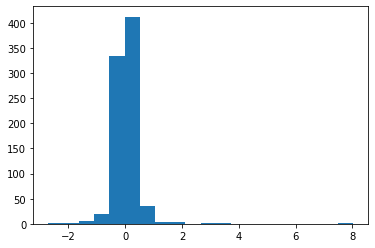

In [115]:
plt.hist(returns,bins=20)
plt.show()

In [152]:
returns

array([-3.76160495e-01, -4.23104732e-01,  7.84366456e-01,  3.20199235e-02,
       -1.12923017e-01,  4.10365056e-01, -2.64184397e-01,  1.62663775e-01,
        1.27789857e-01, -1.24081575e-01, -5.20902661e-01, -1.75732815e-01,
       -9.91912783e-02,  1.61010430e-02, -2.16434730e-01, -1.76570763e-01,
       -1.62516948e-01, -4.64062163e-01, -1.02099823e-01,  2.49631432e-01,
        2.35476682e-01, -8.46084608e-02,  9.54903339e-02,  9.35992512e-02,
       -3.35383398e-01,  3.01327102e-01,  1.43914659e-02, -3.36352108e-01,
        2.70711701e-02,  1.57872421e-01, -1.02680502e-01, -3.62456045e-01,
        3.71013863e-02, -1.34781861e-01, -2.99818841e-01, -2.55294406e-01,
        8.18850876e-01, -1.12931058e-01,  8.32112299e-02, -6.59714064e-01,
        4.33026455e-01,  3.89492754e-01,  6.31597943e-03, -2.95027834e-01,
        5.51986246e-01, -4.38264939e-01,  2.58512379e-01, -4.68810573e-02,
        1.59650753e-01, -1.76506610e-01,  2.75151559e-01,  5.82080556e-01,
        1.44007156e-01,  

In [153]:

(np.sort(returns))

array([-2.70404699e+00, -1.68859267e+00, -1.58268759e+00, -1.40150278e+00,
       -1.39957140e+00, -1.35267407e+00, -1.24674003e+00, -1.22379812e+00,
       -1.04711611e+00, -9.46891725e-01, -9.10000552e-01, -7.51318930e-01,
       -7.44197431e-01, -7.40187182e-01, -7.16944815e-01, -7.14038564e-01,
       -7.09278215e-01, -6.97719965e-01, -6.73793276e-01, -6.68323258e-01,
       -6.64078867e-01, -6.59714064e-01, -6.55084022e-01, -6.37628024e-01,
       -6.18675289e-01, -5.97676924e-01, -5.87222750e-01, -5.71828967e-01,
       -5.57955364e-01, -5.56150824e-01, -5.55268797e-01, -5.49921997e-01,
       -5.44106582e-01, -5.29265013e-01, -5.23508167e-01, -5.22385616e-01,
       -5.20902661e-01, -5.18382265e-01, -5.17974488e-01, -5.17139018e-01,
       -5.07496252e-01, -5.05022781e-01, -5.02249578e-01, -4.97156297e-01,
       -4.96688742e-01, -4.89023591e-01, -4.86233897e-01, -4.83237933e-01,
       -4.67340676e-01, -4.64062163e-01, -4.61581176e-01, -4.61117136e-01,
       -4.60115498e-01, -

In [133]:
[len(np.array_split(returns,5)[i]) for i in np.arange(5)]

[164, 164, 164, 163, 163]

In [164]:
[np.array_split(np.sort(returns),classes)[i].min() for i in np.arange(classes)]

[-2.7040469912049447,
 -0.2221408138927794,
 -0.046832140228803,
 0.08826757001765273,
 0.2363948951927597]

In [160]:
[np.array_split(np.sort(returns),classes)[i].max() for i in np.arange(classes)]

[-0.22269057939316994,
 -0.04688105734815817,
 0.08814102564100867,
 0.2360173445304259,
 8.010543390105429]

In [161]:
classes = 5
labels = np.zeros(returns.shape[0])#-featureWindow
thresholdsMin = [np.array_split(np.sort(returns),classes)[i].min() for i in np.arange(classes)]
thresholdsMax = [np.array_split(np.sort(returns),classes)[i].max() for i in np.arange(classes)]
print(thresholds)


[-0.2221408138927794, -0.046832140228803, 0.08826757001765273]


In [171]:
for i in np.arange(classes):
    
    if i == 0:
        
        labels[(returns <= thresholdsMax[i])] = i
    
    elif i == (classes-1):
        
        labels[(returns >= thresholdsMin[i])] = i
    
    else:
        
        labels[(returns >= thresholdsMin[i])&(returns<=thresholdsMax[i])] = i

In [172]:
labels

array([0., 0., 4., 2., 1., 4., 0., 3., 3., 1., 0., 1., 1., 2., 1., 1., 1.,
       0., 1., 4., 3., 1., 3., 3., 0., 4., 2., 0., 2., 3., 1., 0., 2., 1.,
       0., 0., 4., 1., 2., 0., 4., 4., 2., 0., 4., 0., 4., 1., 3., 1., 4.,
       4., 3., 2., 4., 0., 3., 4., 2., 0., 0., 0., 2., 2., 3., 0., 0., 4.,
       3., 0., 4., 2., 3., 1., 1., 3., 4., 1., 1., 1., 2., 0., 2., 0., 3.,
       2., 2., 0., 1., 4., 0., 3., 1., 1., 1., 3., 1., 2., 2., 0., 0., 0.,
       0., 1., 0., 2., 4., 1., 0., 3., 0., 4., 2., 0., 4., 4., 4., 0., 3.,
       4., 4., 1., 4., 0., 3., 3., 2., 4., 0., 3., 1., 2., 4., 4., 2., 3.,
       3., 2., 4., 2., 3., 2., 4., 0., 0., 2., 4., 3., 2., 3., 0., 4., 1.,
       4., 4., 4., 4., 2., 0., 1., 0., 3., 0., 4., 4., 1., 3., 4., 1., 1.,
       4., 3., 1., 0., 4., 2., 1., 0., 4., 1., 4., 1., 0., 1., 3., 1., 1.,
       1., 4., 0., 0., 4., 4., 0., 4., 0., 0., 0., 4., 1., 3., 4., 4., 0.,
       3., 4., 4., 2., 1., 3., 3., 0., 4., 2., 2., 2., 2., 2., 0., 2., 0.,
       4., 3., 4., 3., 1.

In [173]:
np.unique(labels,return_counts=True)

(array([0., 1., 2., 3., 4.]), array([164, 164, 164, 163, 163], dtype=int64))

In [195]:
npFeatures.shape

(815, 20)

In [176]:
labels.shape

(818,)

In [196]:
labels[5:].shape

(813,)

In [198]:
npFeatures[0:2]

array([[1122.26 , 1128.7  , 1114.79 , 1124.52 , 1124.72 , 1127.85 ,
        1118.26 , 1120.29 , 1120.13 , 1121.68 , 1115.18 , 1115.55 ,
        1115.35 , 1126.   , 1114.3  , 1124.3  , 1124.33 , 1129.31 ,
        1123.   , 1124.66 ],
       [1124.72 , 1127.85 , 1118.26 , 1120.29 , 1120.13 , 1121.68 ,
        1115.18 , 1115.55 , 1115.35 , 1126.   , 1114.3  , 1124.3  ,
        1124.33 , 1129.31 , 1123.   , 1124.66 , 1124.81 , 1127.755,
        1121.52 , 1123.39 ]])

In [199]:
npFeatures[2:].shape

(813, 20)

In [204]:
candleNP[0:7]

array([[1122.26 , 1128.7  , 1114.79 , 1124.52 ],
       [1124.72 , 1127.85 , 1118.26 , 1120.29 ],
       [1120.13 , 1121.68 , 1115.18 , 1115.55 ],
       [1115.35 , 1126.   , 1114.3  , 1124.3  ],
       [1124.33 , 1129.31 , 1123.   , 1124.66 ],
       [1124.81 , 1127.755, 1121.52 , 1123.39 ],
       [1122.58 , 1129.87 , 1121.17 , 1128.   ]])

In [206]:
labels[4]

1.0

In [208]:
returns[4:6]

array([-0.11292302,  0.41036506])

In [209]:
returns[4:].shape

(814,)

In [210]:
returns[0:4]

array([-0.3761605 , -0.42310473,  0.78436646,  0.03201992])

In [212]:
labels.shape

(818,)